In [174]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [175]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [176]:
len(words)

32033

In [177]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [219]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [220]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [180]:
C = torch.randn((27, 2))


In [181]:
C[5]

tensor([0.4292, 0.2281])

In [182]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.4292, 0.2281])

In [183]:
C[X].shape

torch.Size([32, 3, 2])

In [184]:
X[13,2]

tensor(1)

In [185]:
C[X][13,2]

tensor([ 1.8568, -0.4740])

In [186]:
C[1]

tensor([ 1.8568, -0.4740])

In [187]:
emb = C[X]
emb.shape
emb

tensor([[[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [-0.1605, -0.8230]],

        [[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [ 0.4292,  0.2281]],

        [[-0.1605, -0.8230],
         [ 0.4292,  0.2281],
         [ 0.1847, -0.4149]],

        [[ 0.4292,  0.2281],
         [ 0.1847, -0.4149],
         [ 0.1847, -0.4149]],

        [[ 0.1847, -0.4149],
         [ 0.1847, -0.4149],
         [ 1.8568, -0.4740]],

        [[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [-0.1605, -0.8230]],

        [[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [-0.2392,  0.8671]],

        [[-0.1605, -0.8230],
         [-0.2392,  0.8671],
         [ 1.9192,  0.5768]],

        [[-0.2392,  0.8671],
         [ 1.9192,  0.5768],
         [ 0.5699, -0.2114]],

        [[ 1.9192,  0.5768],
         [ 0.5699, -0.2114],
         [-0.6608, -1.0366]],

        [[ 0.5699, -0.2114],
         [-0.6608, -1.0366],
         [ 0.5699, -0.2114]],

        [[-0.6608, -1

In [188]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
# emb @ W1 + b1

In [189]:
# F = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

In [190]:
unbinded = torch.unbind(emb, 1)

In [191]:
# Optimize tensor view manipulation

In [192]:
a = torch.arange(18)

In [193]:
# no memory is being changed/copied/created etc. when .view is being called
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [194]:
# always a 1-dimensional vector
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [195]:
emb.shape

torch.Size([32, 3, 2])

In [196]:
# more efficient and easier than bind/unbind
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [197]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
# pytorch can infer missing shape of matrix with -1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape # 100 activations for each of our 32 examples

torch.Size([32, 100])

In [198]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [199]:
logits = h @ W2 + b2

In [200]:
counts = logits.exp()

In [201]:
prob = counts / counts.sum(1, keepdims=True)

In [202]:
# index into the rows of prob, pluck out the probability assigned to the correct character, and calculate loss
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.5355)

In [203]:
# ---- clearer sequence -----

In [226]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [283]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster parameters into single list

In [284]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [277]:
# emb = C[X] # (32, 3, 2)
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# logits = h @ W2 + b2
# # counts = logits.exp()
# # prob = counts / counts.sum(1, keepdims=True)
# # loss = -prob[torch.arange(32), Y].log().mean()
# # Above 3 commented lines can be done (more efficiently) with the following line
# F.cross_entropy(logits, Y) # how well neural network currently works with this set of parameters

In [285]:
for p in parameters:
    p.requires_grad = True

In [286]:
# step linearly between exponents of possible learning rates and space them exponentially
# creates possible learning rates to use
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [287]:
lri = []
lossi = []

for i in range(1000):
    # minibatch construct of 32 examples
    # better to have approximate gradient and take many more steps than exact gradient with fewer steps 
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lr)
    lossi.append(loss.item())

print (loss.item())

22.062084197998047
19.770092010498047
20.20876693725586
19.104528427124023
20.888774871826172
20.766151428222656
18.481586456298828
17.176937103271484
18.185894012451172
20.055442810058594
19.10376739501953
18.832372665405273
19.973270416259766
20.25736427307129
17.979248046875
15.141725540161133
18.815242767333984
17.711284637451172
18.222579956054688
18.078096389770508
19.77492904663086
20.687910079956055
22.148778915405273
17.118934631347656
18.6136417388916
17.08169174194336
15.157208442687988
20.074481964111328
21.305274963378906
15.500879287719727
17.600276947021484
16.990840911865234
19.302955627441406
20.76592254638672
17.753591537475586
18.2147216796875
18.205339431762695
20.007633209228516
18.457733154296875
17.01404571533203
20.871049880981445
16.717182159423828
19.680606842041016
19.54224967956543
17.434616088867188
19.120203018188477
16.120254516601562
17.20805549621582
16.547056198120117
15.308228492736816
17.74020767211914
16.956031799316406
16.191593170166016
17.7003097

5.26143217086792
6.039442539215088
5.438142776489258
4.5552473068237305
5.036038398742676
4.1901702880859375
4.675171852111816
5.589642524719238
5.954342365264893
4.813277721405029
4.393454074859619
5.179025650024414
5.3705949783325195
6.129430770874023
3.9144704341888428
4.944962978363037
4.354725360870361
5.484531879425049
4.606887340545654
6.445082187652588
5.112035751342773
4.0676774978637695
5.809061527252197
7.591692924499512
6.820897102355957
6.0558624267578125
7.72961950302124
4.810822010040283
4.896105766296387
4.466850757598877
5.856807708740234
4.080012321472168
6.166408538818359
5.207895755767822
4.1589508056640625
5.017277717590332
4.852561950683594
4.114482879638672
6.334842681884766
4.53770112991333
4.83894157409668
5.1012282371521
4.434238910675049
6.933509349822998
7.980774879455566
4.423581600189209
5.078377723693848
4.43633508682251
4.241696357727051
6.316478729248047
7.465280532836914
9.941217422485352
8.520907402038574
6.828598499298096
7.9052886962890625
7.8528180

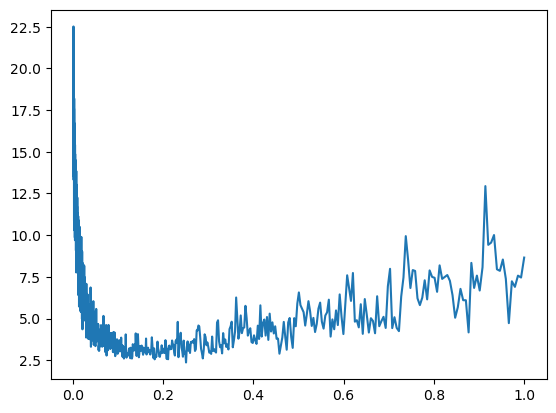

In [288]:
plt.plot(lri, lossi)

In [262]:
emb = C[X] # (32, 3, 2)
print(emb.shape)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

torch.Size([228146, 3, 2])


tensor(2.5397, grad_fn=<NllLossBackward0>)